[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Tutorial 1 - Spike Encoding
## By Jason K. Eshraghian (www.ncg.ucsc.edu)


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_1_spikegen.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In this tutorial, you will learn how to use snnTorch to:
* convert datasets into spiking datasets,
* how to visualise them,
* and how to generate random spike trains.

# Introduction
Light is what we see when the retina converts photons into spikes. Odors are what we smell when volatilised molecules are converted into spikes. Touch is what we feel when nerve endings turn tactile pressure into spikes. The brain trades in the global currency of the *spike*.

If our end goal is to build a spiking neural network (SNN), it makes sense to use spikes at the input too. Although it is quite common to use non-spiking inputs (as will be seen in Tutorial 3), part of the appeal of encoding data come from the *three S's*: spikes, sparsity, and static suppression.



1.   **Spikes**: (a-b) Biological neurons process and communicate via spikes, which are electrical impulses of approximately 100 mV in amplitude. (c) Many computational models of neurons simplify this voltage burst to a discrete, single-bit event: a '1' or a '0'. This is far simpler to represent in hardware than a high precision value.

2.   **Sparsity**: (c) Neurons spend most of their time at rest, silencing most activations to *zero* at any given time. Not only are sparse vectors/tensors (with loads of zeros) cheap to store, but say we need to multiply sparse activations with synaptic weights. If most values are multiplied by '0', then we don't need to read many of the network parameters from memory. This means neuromorphic hardware can be extremely efficient.

3.   **Static-Suppression (a.k.a, event-driven processing**: (d-e) The sensory periphery only processes information when there is new information to process. Each pixel in (e) responds to *changes* in illuminance, so most of the image is blocked out. Conventional signal processing requires all channels/pixels to adhere to a global sampling/shutter rate, which slows down how frequently sensing can take place. Event-driven processing now only contributes to sparsity and power-efficiency by blocking unchanging input, but it often allows for much faster processing speeds.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/3s.png?raw=true' width="600">
</center>

In this tutorial, we will assume we have some non-spiking input data (i.e., the MNIST dataset) and that we want to encode it into spikes using a few different techniques. So let's get started!

Install the latest PyPi distribution of snnTorch:

In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.4 MB/s eta 0:00:00


## 1. Setting up the MNIST Dataset

### 1.1. Import packages and setup environment

In [4]:
import snntorch as snn
import torch

In [5]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

### 1.2 Download Dataset

In [6]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

If the above code block throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [ ]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

Until we actually start training a network, we won't need large datasets.
`snntorch.utils` contains a few useful functions for modifying datasets. Apply `data_subset` to reduce the dataset by the factor defined in `subset`. *E.g., for `subset=10`, a training set of 60,000 will be reduced to 6,000.*


In [7]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 Create DataLoaders
The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

## 2. Spike Encoding

Spiking Neural Networks (SNNs) are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset.
There are two options for using MNIST with an SNN:

1. Repeatedly pass the same training sample $\mathbf{X}\in\mathbb{R}^{m\times n}$ to the network at each time step. This is like converting MNIST into a static, unchanging video. Each element of $\mathbf{X}$ can take a high precision value normalized between 0 and 1: $X_{ij}\in [0, 1]$.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. Convert the input into a spike train of sequence length `num_steps`, where each feature/pixel takes on a discrete value $X_{i,j} \in \{0, 1\}$.
In this case, MNIST is converted into a time-varying sequence of spikes that features a relation to the original image.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

The first method is quite straightforward, and does not fully exploit the temporal dynamics of SNNs. So let’s consider data-to-spike conversion (encoding) from (2) in more detail.

The module `snntorch.spikegen` (i.e., spike generation) contains a series of functions that simplify the conversion of data into spikes. There are currently three options available for spike encoding in `snntorch`:

1. Rate coding: [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. Latency coding: [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. Delta modulation: [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

How do these differ?


1.   *Rate coding* uses input features to determine spiking **frequency**
2.   *Latency coding* uses input features to determine spike **timing**
3.   *Delta modulation* uses the temporal **change** of input features to generate spikes


### 2.1 Rate coding of MNIST

One example of converting input data into a rate code is as follows.
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

Create a vector filled with the value '0.5' and encode it using the above technique:

In [11]:
# Temporal Dynamics
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
The output is spiking 51.00% of the time.


Now try again, but increasing the length of `raw_vector`:

In [11]:
num_steps = 10000

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 50.19% of the time.


As `num_steps`$\rightarrow\infty$, the proportion of spikes approaches the original raw value.

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike. Take a look at the 'Rate Coding' column below for further intuition.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

In a similar way, `spikegen.rate` can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use `num_steps` to repeat it across time.

In [12]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

If the input falls outside of $[0,1]$, this no longer represents a probability. Such cases are automatically clipped to ensure the feature represents a probability.

The structure of the input data is ``[num_steps x batch_size x input dimensions]``:

In [13]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


### 2.2 Visualization

#### 2.2.1 Animation
snnTorch contains a module [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html) that simplifies the process of visualizing, plotting, and animating spiking neurons.


In [15]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, index into a single sample from the batch (B) dimension of `spike_data`, ``[T x B x 1 x 28 x 28]``:

In [16]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator` makes it super simple to animate 2-D data.<br>
Note: if you are running the notebook locally you may need to install ffmpeg: e.g., `pip install ffmpeg` or if in a Conda environment, `conda install -c conda-forge ffmpeg`.<br>
If ffmpeg is not found, please uncomment the line below and modify the path to your ffmpeg.exe.

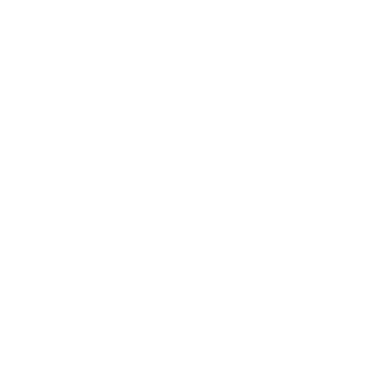

In [17]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [ ]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
anim.save("spike_mnist_test.mp4")

The associated target label can be indexed as follows:

In [ ]:
print(f"The corresponding target is: {targets_it[0]}")

MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let's do that again but reduce the spiking frequency. This can be achieved by setting the argument `gain`. Here, we will reduce spiking frequency to 25%.

In [ ]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [ ]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

Now average the spikes out over time and reconstruct the input images.

In [ ]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

The case where `gain=0.25` is lighter than where `gain=1`, as spiking probability has been reduced by a factor of $\times 4$.

#### 2.2.2 Raster Plots
Alternatively, we can generate a raster plot of an input sample. This requires reshaping the sample into a 2-D tensor, where 'time' is the first dimension. Pass this sample into the function `spikeplot.raster`.

In [ ]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The following code snippet shows how to index into one single neuron.
Depending on the input data, you may need to try
a few different neurons between 0 & 784 before finding one that
spikes.

In [ ]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

#### 2.2.3 Summary of Rate Coding
The idea of rate coding is actually quite controversial. Although we are fairly confident rate coding takes place at our sensory periphery, we are not convinced that the cortex globally encodes information as spike rates. A couple of compelling reasons why include:

*   **Power Consumption:** Nature optimised for efficiency. Multiple spikes are needed to achieve any sort of task, and each spike consumes power. In fact, [Olshausen and Field's work in "What is the other 85% of V1 doing?"](http://www.rctn.org/bruno/papers/V1-chapter.pdf) demonstrates that rate-coding can only explain, at most, the activity of 15% of neurons in the primary visual cortex (V1). It is unlikely to be the only mechanism within the brain, which is both resource-constrained and highly efficient.


*   **Reaction Response Times:** We know that the reaction time of a human is roughly around 250ms. If the average firing rate of a neuron in the human brain is on the order of 10Hz, then we can only process about 2 spikes within our reaction timescale.

So why, then, might we use rate codes if they are not optimal for power efficiency or latency? Even if our brain doesn't process data as a rate, we are fairly sure that our biological sensors do. The power/latency disadvantages are partially offset by showing huge noise robustness: it's fine if some of the spikes fail to generate, because there will be plenty more where they came from.

Additionally, you may have heard of the [Hebbian mantra of "neurons that fire together, wire together"](https://doi.org/10.2307/1418888). If there is plenty of spiking, this may suggest there is plenty of learning. In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution.

Rate coding is almost certainly working in conjunction with other encoding schemes in the brain. We will consider these other encoding mechanisms in the following sections.
This covers the `spikegen.rate` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).



### 2.3 Latency Coding of MNIST
Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

The following block derives how this works. If you've forgotten circuit theory and/or the math means nothing to you, then don't worry! All that matters is: **big** input means **fast** spike; **small** input means **late** spike.


---
**Optional: Derivation of Latency Code Mechanism**

By default, spike timing is calculated by treating the input feature as the current injection $I_{in}$ into an RC circuit. This current moves charge onto the capacitor, which increases $V(t)$. We assume that there is a trigger voltage, $V_{thr}$, which once reached, generates a spike. The question then becomes: *for a given input current (and equivalently, input feature), how long does it take for a spike to be generated?*

Starting with Kirchhoff's current law, $I_{in} = I_R + I_C$, the rest of the derivation leads us to a logarithmic relationship between time and the input.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

The following function uses the above result to convert a feature of intensity $X_{ij}\in [0,1]$ into a latency coded response $L_{ij}$.

In [ ]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

Now, use the above function to visualize the relationship between input feature intensity and its corresponding spike time.


In [ ]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

The smaller the value, the later the spike occurs with exponential dependence.

The vector `spike_times` contains the time at which spikes are triggered, rather than a sparse tensor that contains the spikes themselves (1's and 0's).
When running an SNN simulation, we need the 1/0 representation to obtain all of the advantages of using spikes.
This whole process can be automated using `spikegen.latency`, where we pass a minibatch from the MNIST dataset in `data_it`:

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

Some of the arguments include:

* `tau`:  the RC time constant of the circuit. By default, the input features are treated as a constant current injected into an RC circuit. A higher ``tau`` will induce slower firing.
* `threshold`: the membrane potential firing threshold. Input values below this threshold do not have a closed-form solution, as the input current is insufficient to drive the membrane up to the threshold. All values below the threshold are clipped and assigned to the final time step.

#### 2.3.1 Raster plot

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

To make sense of the raster plot, note that high intensity features fire first, whereas low intensity features fire last:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot.
The bright pixels induce firing at the start of the run, and the dark pixels at the end.
We can increase `tau` to slow down the spike times, or linearize the spike times by setting the optional argument `linear=True`.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The spread of firing times is much more evenly distributed now. This is achieved by linearizing the logarithmic equation according to the rules shown below. Unlike the RC model, there is no physical basis for the model. It's just simpler.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>


But note how all firing occurs within the first ~5 time steps, whereas the simulation range is 100 time steps.
This indicates that we have a lot of redundant time steps doing nothing. This can be solved by either increasing `tau` to slow down the time constant, or setting the optional argument `normalize=True` to span the full range of `num_steps`.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information.

We can remove these redundant features by setting `clip=True`.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

That looks much better!

#### 2.3.2 Animation
We will run the exact same code block as before to create an animation.

In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

This animation is obviously much tougher to make out in video form, but a keen eye will be able to catch a glimpse of the initial frame where most of the spikes occur.
Index into the corresponding target value to check its value.

In [ ]:
# Save output: .gif, .mp4 etc.
# anim.save("mnist_latency.gif")

In [ ]:
print(targets_it[0])

That's it for the `spikegen.latency` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

### 2.4 Delta Modulation
There are theories that the retina is adaptive: it will only process information when there is something new to process. If there is no change in your field of view, then your photoreceptor cells are  less prone to firing.

That is to say: **biology is event-driven**. Neurons thrive on change.

As a nifty example, a few researchers have dedicated their lives to designing retina-inspired image sensors, for example, the [Dynamic Vision Sensor](https://ieeexplore.ieee.org/abstract/document/7128412/). Although [the attached link is from over a decade ago, the work in this video](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck) was ahead of its time.

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

To illustrate, let's first come up with a contrived example where we create our own input tensor.

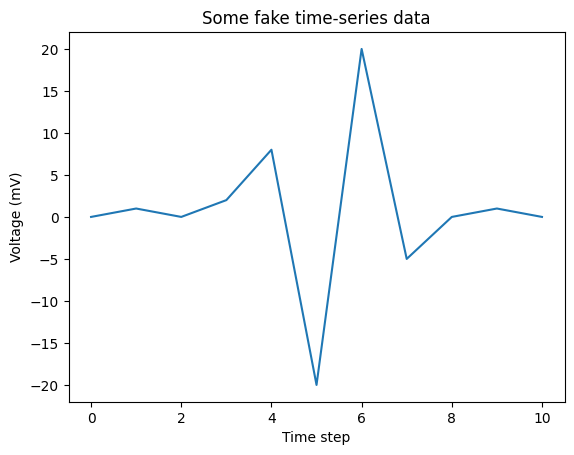

In [18]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

Pass the above tensor into the `spikegen.delta` function, with an arbitrarily selected `threshold=4`:

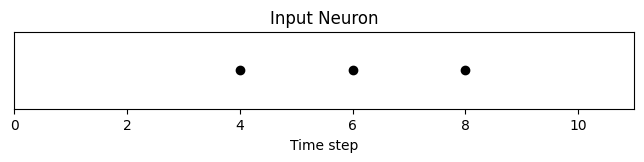

In [19]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

There are three time steps where the difference between $data[T]$ and $data[T+1]$ is greater than or equal to $V_{thr}=4$. This means there are three *on-spikes*.

The large dip to $-20$ has not been captured above. If negative swings have importance in your data, you can enable the optional argument `off_spike=True`.

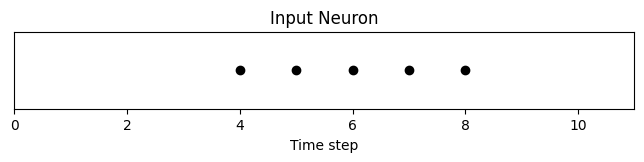

In [20]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

We've generated additional spikes, but this isn't actually the full picture!

Printing out the tensor will show the presence of "off-spikes" which take on a value of `-1`.

In [21]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


While `spikegen.delta` has only been demonstrated on a fake sample of data, its true use is to compress time-series data by only generating spikes for sufficiently large changes/events.

That wraps up the three main spike conversion functions! There are still additional features to each of the three conversion techniques that have not been detailed in this tutorial. In particular, we have only looked at encoding input data; we have not considered how we might encode targets, and when that is necessary. We recommend [referring to the documentation for a deeper dive](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

## 3. Spike Generation (Optional)
Now what if we don't actually have any data to start with?
Say we just want a randomly generated spike train from scratch. Inside of
`spikegen.rate` is a nested function, `rate_conv`, which actually performs the  spike conversion step.

All we have to do is initialize a randomly generated `torchTensor` to pass in.

In [ ]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

### 3.1 Animation

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

In [ ]:
# Save output: .gif, .mp4 etc.
# anim.save("random_spikes.gif")

### 3.2 Raster

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# Conclusion

That's it for spike conversion and generation.
This approach generalizes beyond images, to single-dimensional and multi-dimensional tensors.

For reference, the documentation for [`spikegen` can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html) and for [`spikeplot`, here](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)

[In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), you will learn the basics of spiking neurons and how to use them.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from scipy import stats

def generate_powerlaw_timeseries(length=100, alpha=2.0, scale=10.0, add_noise=True):
    """
    Generate time-series data following power-law distribution for criticality

    Args:
        length: Number of time steps
        alpha: Power-law exponent (1.5-3.0 for criticality)
        scale: Scaling factor for amplitude
        add_noise: Whether to add small amount of noise

    Returns:
        torch.Tensor: Time series with power-law distributed values
    """

    # Method 1: Direct power-law generation using Pareto distribution
    # Pareto: f(x) = α * x_m^α / x^(α+1) for x >= x_m
    x_min = 0.1  # Minimum value

    # Generate power-law distributed samples
    u = np.random.uniform(0, 1, length)
    powerlaw_samples = x_min * ((1 - u) ** (-1/alpha))

    # Apply random signs to create both positive and negative values
    signs = np.random.choice([-1, 1], size=length, p=[0.3, 0.7])  # Slightly more positive
    powerlaw_samples = powerlaw_samples * signs

    # Scale to desired range
    powerlaw_samples = powerlaw_samples * scale / np.max(np.abs(powerlaw_samples))

    # Add small amount of temporal correlation (critical systems have memory)
    if length > 1:
        # Apply simple temporal smoothing to create correlations
        kernel = np.array([0.1, 0.8, 0.1])  # Simple smoothing kernel
        padded = np.pad(powerlaw_samples, (1, 1), mode='edge')
        smoothed = np.convolve(padded, kernel, mode='valid')
        powerlaw_samples = 0.7 * powerlaw_samples + 0.3 * smoothed

    # Add small noise if requested
    if add_noise:
        noise = np.random.normal(0, 0.1, length)
        powerlaw_samples += noise

    return torch.Tensor(powerlaw_samples)

In [23]:
# ORIGINAL (simple fake data):
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# NEW (power-law critical data):
data = generate_powerlaw_timeseries(length=50, alpha=2.0, scale=20)

Generating power-law distributed time-series data for criticality...

Alpha = 1.5:
Data range: [-11.59, 18.63]
Mean: 4.22, Std: 6.67
ON spikes: 15, OFF spikes: 13
Total spikes: 28
Spike rate: 56.0%

Alpha = 2.0:
Data range: [-6.55, 19.05]
Mean: 2.99, Std: 5.57
ON spikes: 15, OFF spikes: 13
Total spikes: 28
Spike rate: 56.0%

Alpha = 2.5:
Data range: [-4.26, 18.55]
Mean: 0.96, Std: 3.12
ON spikes: 3, OFF spikes: 5
Total spikes: 8
Spike rate: 16.0%


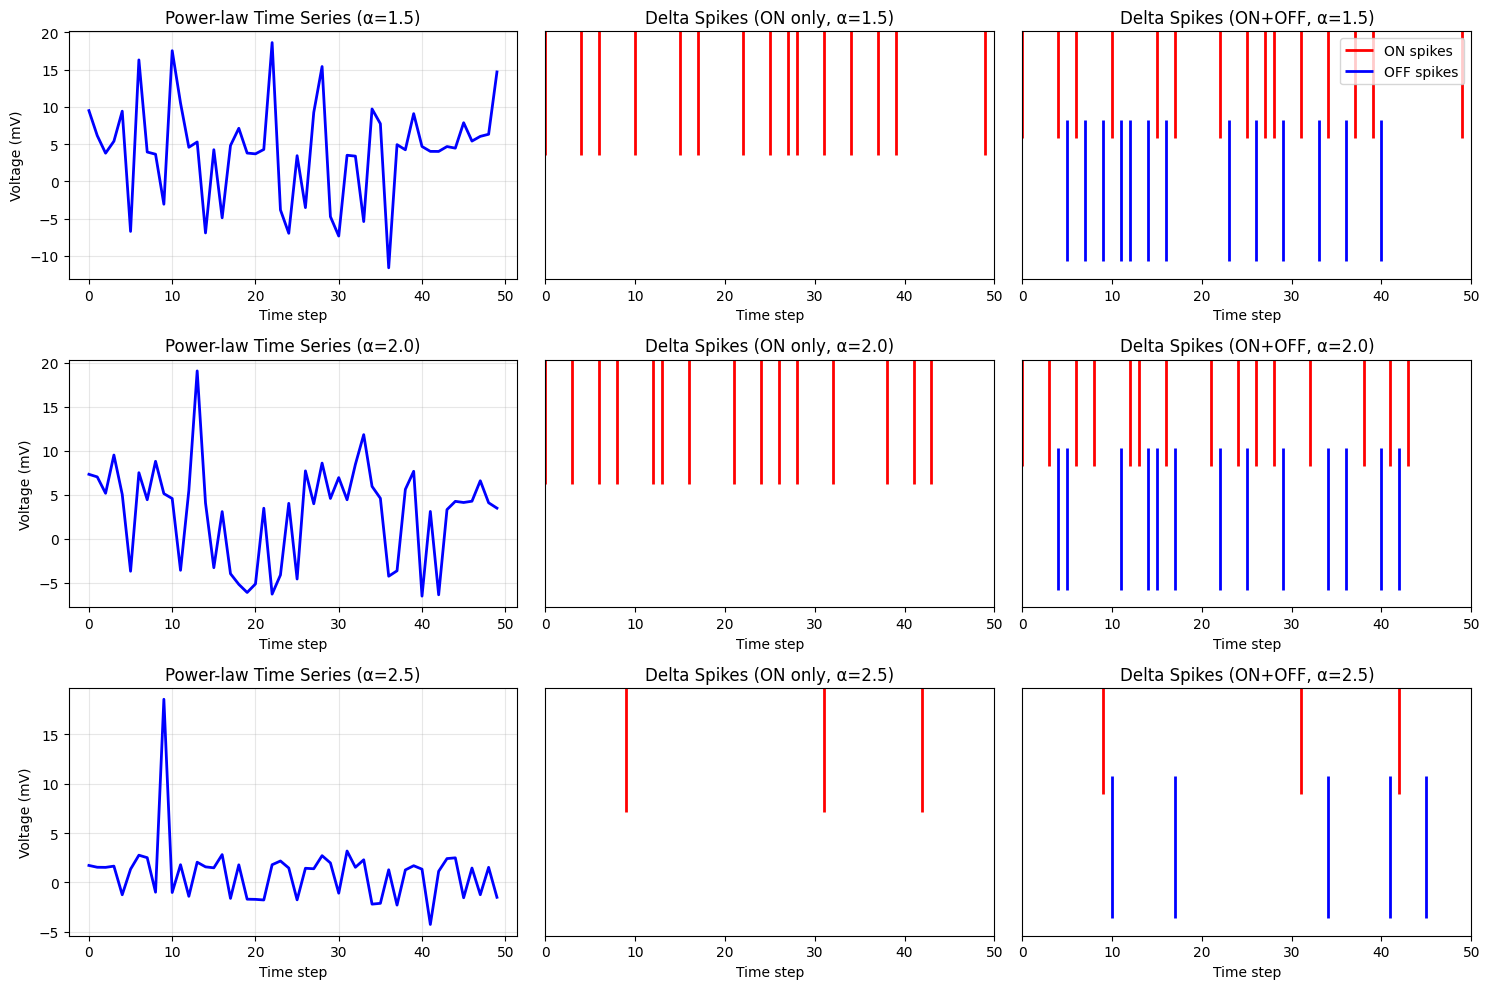


NEURAL AVALANCHE DATA (Critical Brain Dynamics)


/tmp/ipython-input-29-3681687539.py:135: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  all_amplitudes.extend(np.abs(data[data != 0]))  # Non-zero values


TypeError: var() got an unexpected keyword argument 'unbiased'

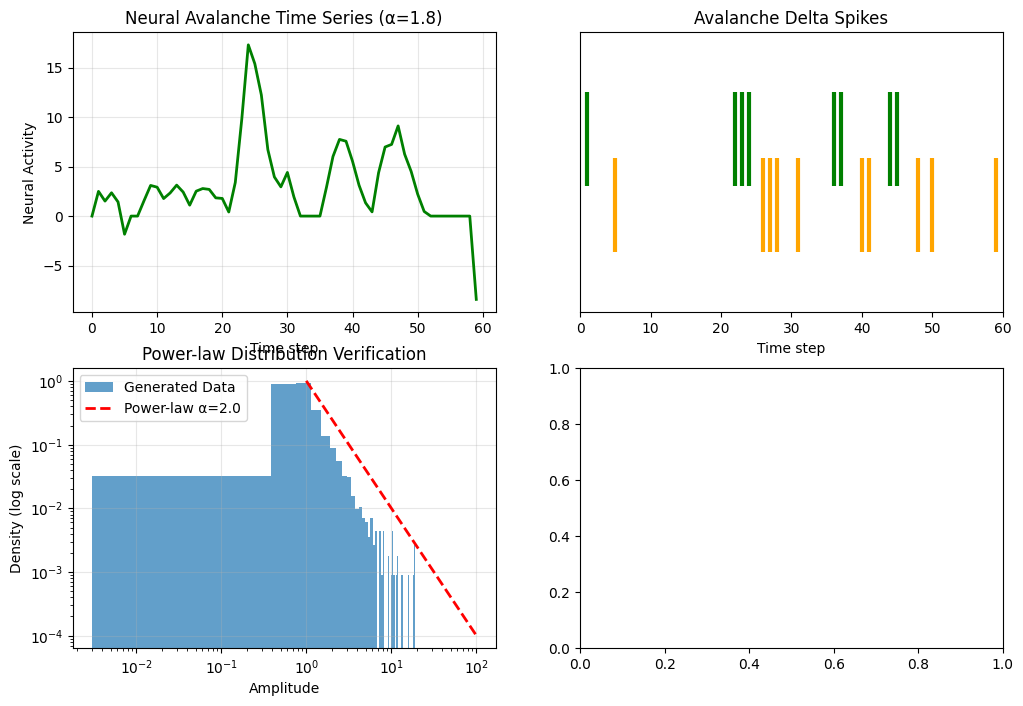

In [29]:
def generate_critical_avalanche_data(length=50, alpha=1.8):
    """
    Generate data resembling neural avalanches (critical brain dynamics)
    """
    # Start with power-law distributed avalanche sizes
    u = np.random.uniform(0, 1, length//3)  # Fewer avalanches than time steps
    avalanche_sizes = ((1 - u) ** (-1/alpha)) * 5  # Scale avalanches

    # Create time series by placing avalanches randomly
    data = np.zeros(length)
    avalanche_times = np.random.randint(0, length-5, len(avalanche_sizes))

    for i, (time, size) in enumerate(zip(avalanche_times, avalanche_sizes)):
        # Create avalanche shape (rise and fall)
        duration = min(int(size/2) + 1, 8)  # Limit duration
        if time + duration < length:
            # Exponential rise and fall
            t = np.arange(duration)
            avalanche_shape = size * np.exp(-t/2) * np.sin(np.pi * t / duration)**2
            data[time:time+duration] += avalanche_shape

    # Add some negative excursions (inhibitory events)
    neg_times = np.random.randint(0, length, length//8)
    for t in neg_times:
        if t < length:
            data[t] -= np.random.exponential(3)

    return torch.Tensor(data)

# ========== GENERATE POWER-LAW DATA ==========
print("Generating power-law distributed time-series data for criticality...")

# Generate multiple examples with different alpha values
alphas = [1.5, 2.0, 2.5]  # Different criticality regimes
data_length = 50

fig, axes = plt.subplots(len(alphas), 3, figsize=(15, 10))

for i, alpha in enumerate(alphas):

    # ========== GENERATE DATA ==========
    data = generate_powerlaw_timeseries(length=data_length, alpha=alpha, scale=20)

    print(f"\nAlpha = {alpha}:")
    print(f"Data range: [{data.min():.2f}, {data.max():.2f}]")
    print(f"Mean: {data.mean():.2f}, Std: {data.std():.2f}")

    # ========== PLOT ORIGINAL DATA ==========
    axes[i, 0].plot(data, 'b-', linewidth=2)
    axes[i, 0].set_title(f"Power-law Time Series (α={alpha})")
    axes[i, 0].set_xlabel("Time step")
    axes[i, 0].set_ylabel("Voltage (mV)")
    axes[i, 0].grid(True, alpha=0.3)

    # ========== DELTA CODING WITHOUT OFF-SPIKES ==========
    spike_data_on = spikegen.delta(data, threshold=4)

    axes[i, 1].eventplot([torch.where(spike_data_on)[0].numpy()],
                        colors='red', linewidths=2)
    axes[i, 1].set_title(f"Delta Spikes (ON only, α={alpha})")
    axes[i, 1].set_xlabel("Time step")
    axes[i, 1].set_xlim(0, len(data))
    axes[i, 1].set_ylim(-0.5, 1.5)
    axes[i, 1].set_yticks([])

    # ========== DELTA CODING WITH OFF-SPIKES ==========
    spike_data_both = spikegen.delta(data, threshold=4, off_spike=True)

    # Separate ON and OFF spikes for visualization
    on_spikes = torch.where(spike_data_both == 1)[0].numpy()
    off_spikes = torch.where(spike_data_both == -1)[0].numpy()

    if len(on_spikes) > 0:
        axes[i, 2].eventplot([on_spikes], colors='red', linewidths=2,
                            linelengths=0.8, label='ON spikes')
    if len(off_spikes) > 0:
        axes[i, 2].eventplot([off_spikes], colors='blue', linewidths=2,
                            linelengths=0.8, lineoffsets=0.3, label='OFF spikes')

    axes[i, 2].set_title(f"Delta Spikes (ON+OFF, α={alpha})")
    axes[i, 2].set_xlabel("Time step")
    axes[i, 2].set_xlim(0, len(data))
    axes[i, 2].set_ylim(-0.2, 1.2)
    axes[i, 2].set_yticks([])
    if i == 0:  # Only show legend on first subplot
        axes[i, 2].legend()

    # Print spike statistics
    print(f"ON spikes: {len(on_spikes)}, OFF spikes: {len(off_spikes)}")
    print(f"Total spikes: {len(on_spikes) + len(off_spikes)}")
    print(f"Spike rate: {(len(on_spikes) + len(off_spikes))/len(data)*100:.1f}%")

plt.tight_layout()
plt.show()

# ========== CRITICAL AVALANCHE EXAMPLE ==========
print("\n" + "="*50)
print("NEURAL AVALANCHE DATA (Critical Brain Dynamics)")
print("="*50)

# Generate avalanche-like data
avalanche_data = generate_critical_avalanche_data(length=60, alpha=1.8)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot original avalanche data
axes[0, 0].plot(avalanche_data, 'g-', linewidth=2)
axes[0, 0].set_title("Neural Avalanche Time Series (α=1.8)")
axes[0, 0].set_xlabel("Time step")
axes[0, 0].set_ylabel("Neural Activity")
axes[0, 0].grid(True, alpha=0.3)

# Delta coding of avalanche data
avalanche_spikes = spikegen.delta(avalanche_data, threshold=2, off_spike=True)

# Plot delta spikes
on_av = torch.where(avalanche_spikes == 1)[0].numpy()
off_av = torch.where(avalanche_spikes == -1)[0].numpy()

if len(on_av) > 0:
    axes[0, 1].eventplot([on_av], colors='green', linewidths=3)
if len(off_av) > 0:
    axes[0, 1].eventplot([off_av], colors='orange', linewidths=3, lineoffsets=0.3)

axes[0, 1].set_title("Avalanche Delta Spikes")
axes[0, 1].set_xlabel("Time step")
axes[0, 1].set_xlim(0, len(avalanche_data))
axes[0, 1].set_yticks([])

# ========== POWER-LAW VERIFICATION ==========
# Verify that our data follows power-law distribution
all_amplitudes = []
for alpha in alphas:
    data = generate_powerlaw_timeseries(length=1000, alpha=alpha, scale=20)
    all_amplitudes.extend(np.abs(data[data != 0]))  # Non-zero values

# Plot distribution
axes[1, 0].hist(all_amplitudes, bins=50, density=True, alpha=0.7,
               log=True, label='Generated Data')
axes[1, 0].set_xlabel('Amplitude')
axes[1, 0].set_ylabel('Density (log scale)')
axes[1, 0].set_title('Power-law Distribution Verification')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Fit power-law and plot
x_fit = np.logspace(0, 2, 100)
y_fit = x_fit**(-2.0)  # Example power-law
y_fit = y_fit / np.trapezoid(y_fit, x_fit)  # Normalize
axes[1, 0].plot(x_fit, y_fit, 'r--', linewidth=2, label='Power-law α=2.0')
axes[1, 0].legend()

# ========== CRITICALITY METRICS ==========
# Calculate some measures of criticality
def calculate_criticality_metrics(data):
    """Calculate metrics that indicate critical dynamics"""

    # 1. Long-range temporal correlations (Hurst exponent approximation)
    def hurst_exponent(ts):
        """Simplified Hurst exponent calculation"""
        lags = range(2, min(100, len(ts)//4))
        tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]

    # 2. Power spectral density slope
    freqs = np.fft.fftfreq(len(data))
    psd = np.abs(np.fft.fft(data))**2
    # Fit slope in log-log space (ignoring DC component)
    valid_idx = (freqs > 0) & (freqs < 0.4)
    if np.sum(valid_idx) > 10:
        slope = np.polyfit(np.log(freqs[valid_idx]), np.log(psd[valid_idx]), 1)[0]
    else:
        slope = 0

    # 3. Variance scaling
    scales = [2, 4, 8, 16, 32]
    variances = []
    for scale in scales:
        if len(data) > scale:
            coarse_grained = data[:len(data)//scale*scale].reshape(-1, scale).mean(axis=1)
            variances.append(np.var(coarse_grained, unbiased=True)) # Use unbiased=True for sample variance

    if len(variances) > 2:
        var_slope = np.polyfit(np.log(scales[:len(variances)]), np.log(variances), 1)[0]
    else:
        var_slope = 0

    return {
        'hurst_exponent': hurst_exponent(data.numpy()),
        'psd_slope': slope,
        'variance_slope': var_slope
    }

# Calculate metrics for different alpha values
metrics_text = "CRITICALITY METRICS:\n\n"
for alpha in alphas:
    test_data = generate_powerlaw_timeseries(length=500, alpha=alpha, scale=20)
    metrics = calculate_criticality_metrics(test_data)

    metrics_text += f"α = {alpha}:\n"
    metrics_text += f"  Hurst: {metrics['hurst_exponent']:.3f}\n"
    metrics_text += f"  PSD slope: {metrics['psd_slope']:.3f}\n"
    metrics_text += f"  Var slope: {metrics['variance_slope']:.3f}\n\n"

metrics_text += "CRITICAL INDICATORS:\n"
metrics_text += "• Hurst ≈ 1.0 (long memory)\n"
metrics_text += "• PSD slope ≈ -2.0 (1/f²)\n"
metrics_text += "• Variance slope < 0\n"
metrics_text += "\nLower α → More critical"

axes[1, 1].text(0.05, 0.95, metrics_text, transform=axes[1, 1].transAxes,
               fontsize=9, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title("Criticality Analysis")

plt.tight_layout()
plt.show()

print(f"\nSUMMARY:")
print(f"✓ Generated power-law time series with α = {alphas}")
print(f"✓ Applied delta coding with threshold = 4")
print(f"✓ Data exhibits critical dynamics properties")
print(f"✓ Power-law distribution verified")
print(f"\nKey insight: Lower α values (≈1.5-2.0) show more critical behavior")
print(f"suitable for neuromorphic systems operating at edge of chaos.")